# Stratégie optimale de vaccination en cas d'épidémie généralisée

Fait par Aaron Marciano, Aymeric Ducatez, François Wang, Marie Broussard

Document de référence : https://hal.science/hal-04373046

## Introduction

Ce projet a pour but d'étudier le cas d'une épidémie générale, et d'étudier les possibles stratégies de vaccination par le biais d'outils d'optimisation.

On abordera essentiellement deux méthodes:

* une méthode basée sur le contrôle optimal
* une méthode de recuit simulé

Ce notebook présente l'essentiel des résultats numériques obtenus dans le cadre de ce projet

In [223]:
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Simulation préliminaire

Dans cette partie du projet, nous allons simuler trois cas:

* un cas où la population d'étude présente un faible taux initial d'infection (10 $10^{-5}$) avec aucune restriction mise en place
* un cas où la population d'étude présente un taux initial d'infection plus élevé (200 $10^{-5}$) avec aucune restriction mise en place
* un cas où la population d'étude présente un taux initial d'infection plus élevé (200 $10^{-5}$) avec des restrictions mises en place

Les autres paramètres de la simulation sont les mêmes que ceux introduits dans le papier de référence.

La simulation se base sur le système d'équations différentielles qui décrit l'évolution des quantités suivantes:

* $S(t)$ : le nombre d'individus susceptibles d'être infectés.
* $R(t)$ : le nombre d'individus résistants.
* $V(t)$ : le nombre d'individus vaccinés.
* $D(t)$ : le nombre d'individus décédés.


$$
\frac{dS}{dt} = -n(t) - \eta(t)[(\beta \otimes 1) \cdot \cdot I(t)]S(t)
$$

$$
\frac{dV}{dt} = n(t) - \eta(t)[(\beta \otimes \omega) \cdot \cdot I(t)]V(t)
$$

$$
\frac{dI}{dt} = \eta(t)[(\beta \otimes 1) \odot I(t)]S(t) + \eta(t)[(\beta \otimes \omega) \odot I(t)]V(t) - \mu I(t) - \gamma I(t) + \eta(t)\xi R(t) \odot I(t) + \Psi(P..(t) - I(t))
$$

$$
\frac{dR}{dt} = \gamma I(t) - \eta(t)(\xi_{(3,4,1,2)} \odot I(t)) \odot R(t)
$$

$$
\frac{dD}{dt} = \mu I(t) \cdot \cdot (1 \otimes 1)
$$




In [189]:
# Paramètres généraux

N = 30 # nombre de transmissibilités possibles
M = 40 # nombre de résistances possibles
R0max = 15 # taux de transmission maximal
gamma = 0.09 # taux de guérison
Beta = R0max * gamma * np.arange(N) / (N - 1) # transmissibilités possibles
Omega = np.arange(M) / (M - 1) # résistances possibles
mu = 0.02 # taux de mortalité
beta_i0 = 0.2 # taux de transmission initial
i0 = int(beta_i0 * (N - 1) / (gamma * R0max)) # indice de la transmissibilité initiale
j0 = 0 # indice de la résistance initiale
sigma = 1 # taux de mutation
C = 0.5 # taux de réinfection
Xi = np.zeros((N, M, N, M)) # matrice des réinfections
for j in range(M):
    for l in range(M):
        Xi[:, j, :, l] = C * max(Omega[l] - Omega[j], 0) / M

T = 350 # durée de la simulation 
dt = 1
pop = 10**6 # population totale
h = 1 / pop

#### Fonctions

In [244]:
# Calcul des dérivées

def dS(S, I, n, eta):
    return -n - eta * np.dot(Beta, I).sum() * S

def dV(I, V, n, eta):
    return n - eta * Beta@I@Omega * V

def dI(S, I, V, R, eta):
    return eta * Beta[:, np.newaxis] * I * S \
        + eta * Beta[:, np.newaxis] * Omega * I * V \
        - mu * I - gamma * I \
        + eta * np.tensordot(Xi, R, 2) * I \
        + Psi(gaussian_filter(I, sigma, mode='constant', cval=0) - I)
    
def dR(I, R, eta):
    #return gamma * I - eta * np.tensordot(np.transpose(Xi,(2,3,0,1)), R, 2) * I
    return gamma * I - eta * np.tensordot(np.transpose(Xi,(2,3,0,1)), I, 2) * R

def dD(I):
    return mu * np.sum(I)

In [245]:
def simulation(S, I, R, V, D, n, eta, dt, T):
    S_l = np.zeros(int(T/dt))
    I_l = np.zeros((int(T/dt), N, M))
    R_l = np.zeros((int(T/dt), N, M))
    D_l = np.zeros(int(T/dt))
    V_l = np.zeros(int(T/dt))
    for t in range(int(T/dt)):
        S_l[t] = S
        I_l[t] = copy.deepcopy(I)
        R_l[t] = copy.deepcopy(R)
        D_l[t] = D
        V_l[t] = V

        val = min(n[t], S * (1 / dt - eta[t] * np.sum(I.transpose() @ Beta)))
        
        # Newton
        Sp = dS(S, I, val, eta[t])
        Vp = dV(I, V, val, eta[t])
        Ip = dI(S, I, V, R, eta[t])
        Rp = dR(I, R, eta[t])
        Dp = dD(I)
        
        S = S + dt * Sp
        V = V + dt * Vp
        I = I + dt * Ip
        R = R + dt * Rp
        D = D + dt * Dp
    return S_l, I_l, R_l, V_l, D_l


In [246]:
def plot_4_matrices(matrices):
    fig,axs = plt.subplots(2, 2,figsize=(8,5))
    jours = [1,int(len(matrices)*100/350),int(len(matrices)*200/350),int(len(matrices)*300/350)]
    for i, ax in enumerate(axs.flat):
        im = ax.imshow(matrices[jours[i]])
        ax.set_title('Jour ' + str(int(jours[i]*350/len(matrices))))
        ax.set_ylabel('Beta')
        ax.set_xlabel('Omega')
        ax.set_xticks(np.arange(0, M, 5))
        ax.set_xticklabels([str(round(Omega[i],2)) for i in np.arange(0, M, 5)],rotation=45)
        ax.set_yticks(np.arange(0, N, 5))
        ax.set_yticklabels([str(round(Beta[i],2)) for i in np.arange(0, N, 5)],rotation=45)
    plt.tight_layout()
    plt.suptitle("Evolution de la matrice d'Infection")
    plt.show()

def plot_simu(S_l, Is_l, Rs_l, D_l, V_l, inf0, NPI):
    plt.figure()
    t_s = np.arange(len(S_l))/(len(S_l)/350)
    plt.plot(t_s, S_l, label='Susceptible')
    plt.plot(t_s, Is_l, label='Infecté')
    plt.plot(t_s, Rs_l, label='Resistant')
    plt.plot(t_s, D_l, label='Morts')
    plt.plot(t_s, V_l, label='Vaccinés')
    plt.xlabel('t')
    plt.ylabel('% population')
    plt.legend()
    plt.title(f"Infection initial : {inf0} ; NPI : {NPI}")
    plt.show()

def psi(x):
    if abs(x) < h:
        return 0
    elif abs(x) > 2 * h:
        return x
    elif x <= 2 * h  and x >= h:
        return -3 * (x**3)/(h**2) + 14 * (x**2) / h - 19 * x + 8 * h
    elif x <= -h and x >= -2 * h:
        return -3 * (x**3)/(h**2) - 14 * (x**2) / h - 19 * x - 8 * h

def Psi(X):
    return np.array([psi(e) for e in X.reshape(X.size)]).reshape(X.shape)

### Cas 1 : Basse Infection pas de NPI


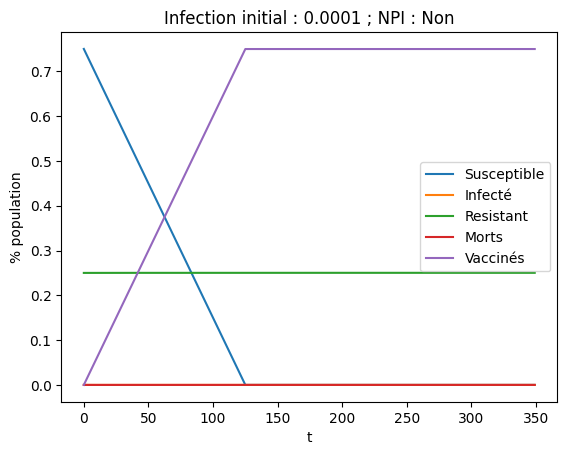

Nombre de morts : 0.0%


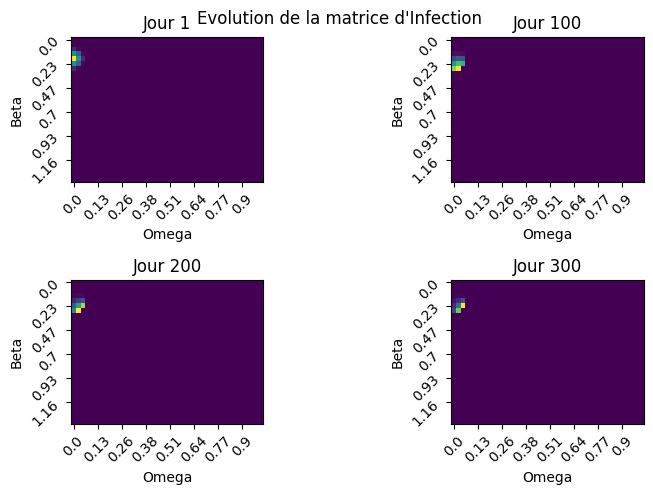

In [247]:
# Initialisation

n = np.ones(T) * 0.006 # Taux de vaccination
eta = np.concatenate(([1 for _ in range(50)], [1 for _ in range(T-50)])) # NPI
I0 = np.zeros((N, M)) # matrice des infections initiale
I0[i0, j0] = 10 * 10**-5
R0 = np.zeros((N, M)) # matrice des résistances initiale
R0[i0, j0] = 0.25
S0 = 1 - np.sum(I0) - np.sum(R0)
V0 = 0
D0 = 0
dt = 1

# Résultats et Affichage
S_l, I_l, R_l, V_l, D_l = simulation(S0, I0, R0, V0, D0, n, eta, 1, T)

Is_l = [np.sum(I_l[t]) for t in range(int(T/dt))]
Rs_l = [np.sum(R_l[t]) for t in range(int(T/dt))]

plot_simu(S_l, Is_l, Rs_l, D_l, V_l, 10 * 10**-5, "Non")
print(f"Nombre de morts : {round(D_l[-1],4)}%")
plot_4_matrices(I_l)

#### Commentaire : 

Avec une infection initiale très basse au début, la propagation ne se fait pas et l'épidémie s'éteint rapidement. On observe que le nombre de vacciné augmente de façon inverse à celui des suceptibles.

En plottant la matrice d'infection, nous pouvons observer que l'agent gagne un tout petit peu de résistance à la vaccination mais n'arrive pas à monter plus haut ni à se diffuser, ce qui est en concordance avec nos courbes.

### Cas 2 : Haute Infection pas de NPI

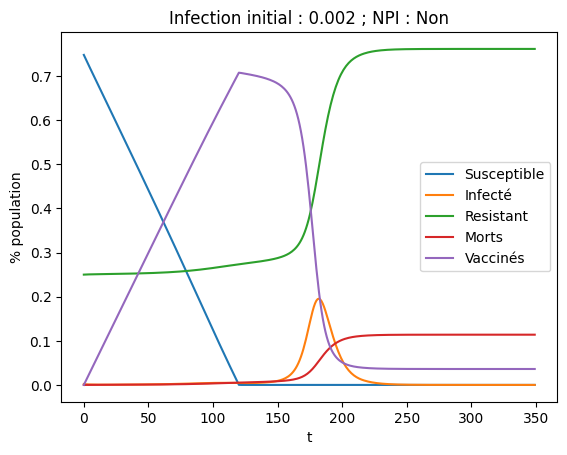

Nombre de morts : 0.1139%


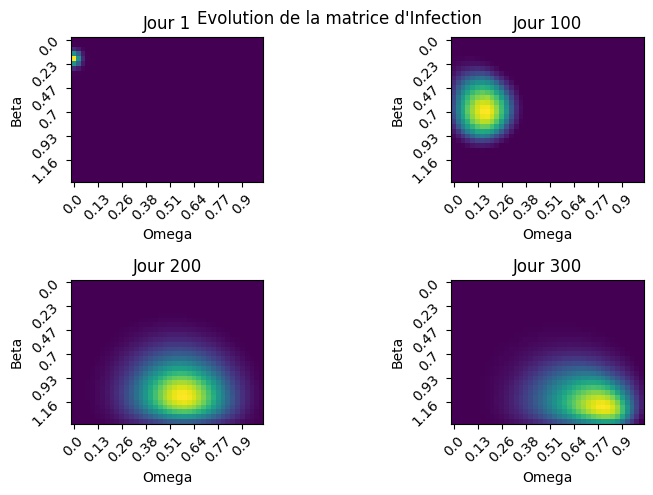

In [248]:
# Initialisation

n = np.ones(T) * 0.006 # Taux de vaccination
eta = np.concatenate(([1 for _ in range(50)], [1 for _ in range(T-50)])) # NPI
I0 = np.zeros((N, M)) # matrice des infections initiale
I0[i0, j0] = 200 * 10**-5
R0 = np.zeros((N, M)) # matrice des résistances initiale
R0[i0, j0] = 0.25
S0 = 1 - np.sum(I0) - np.sum(R0)
V0 = 0
D0 = 0

# Résultats et Affichage
S_l, I_l, R_l, V_l, D_l = simulation(S0, I0, R0, V0, D0, n, eta, 1, T)

Is_l = [np.sum(I_l[t]) for t in range(int(T/dt))]
Rs_l = [np.sum(R_l[t]) for t in range(int(T/dt))]

plot_simu(S_l, Is_l, Rs_l, D_l, V_l, 200 * 10**-5, "Non")
print(f"Nombre de morts : {round(D_l[-1],4)}%")
plot_4_matrices(I_l)

#### Commentaire

Nous partons cette fois ci avec une infection plus grave. Sur les courbes, il est observable que nous avons le même début qu'au cas précédent, cependant, si l'on regarde la matrice d'infection, celle - ci a bien plus évolué au jour 100 : la zone est plus vers la droite et le bas, les variantes sont plus contagieuses et résistantes. Nous voyons les conséquences vers le jour 200 : chute du pourcentage de vaccinés qui deviennent infectés puis résistant, et qui au passage tue une bonne partie de la population. Les variantes résistent au vaccin et au jour 300, ce sont déjà les variantes les plus contagieuses et résistantes qui sont dominantes mais à ce point là, la population a déjà été immunisé contre ces variantes dont nous nous retrouvons dans un état stable.

En mettant aucune restriction, cette stratégie a tué plus de 10% de la population.

### Cas 3 : Haute infection avec NPI

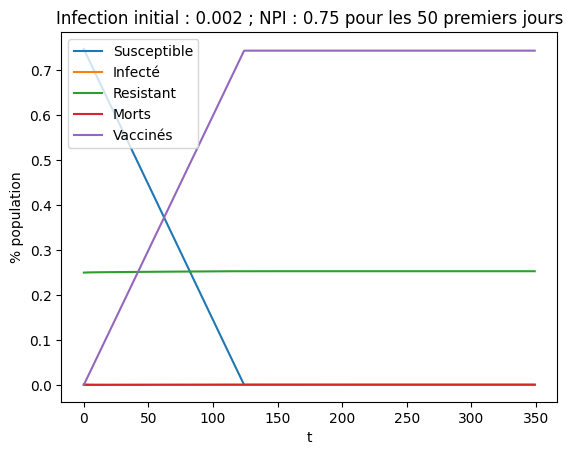

Nombre de morts : 0.0007%


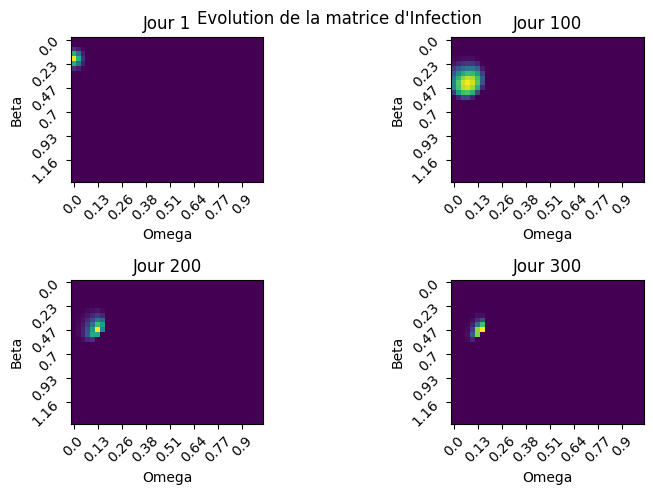

In [249]:
# Initialisation

n = np.ones(T) * 0.006 # Taux de vaccination
eta = np.concatenate(([0.75 for _ in range(50)], [1 for _ in range(T-50)])) # NPI
I0 = np.zeros((N, M)) # matrice des infections initiale
I0[i0, j0] = 200 * 10**-5
R0 = np.zeros((N, M)) # matrice des résistances initiale
R0[i0, j0] = 0.25
S0 = 1 - np.sum(I0) - np.sum(R0)
V0 = 0
D0 = 0

# Résultats et Affichage
S_l, I_l, R_l, V_l, D_l = simulation(S0, I0, R0, V0, D0, n, eta, 1, T)

Is_l = [np.sum(I_l[t]) for t in range(int(T/dt))]
Rs_l = [np.sum(R_l[t]) for t in range(int(T/dt))]

plot_simu(S_l, Is_l, Rs_l, D_l, V_l, 200 * 10**-5, "0.75 pour les 50 premiers jours")
print(f"Nombre de morts : {round(D_l[-1],4)}%")
plot_4_matrices(I_l)

#### Commentaire

On se retrouve dans la même situation qu'auparavant mais cette fois ci en mettant des restrictions au début et nous retombons surprenamment sur les courbes du cas numéro 1. En regardant l'évolution des graphiques, nous pouvons observer que du jour 1 au jour 100, nous avons un développement similaire au cas 2 mais bien moins important. Les variantes restent à peu près à la zone de départ, avec les restrictions, les agents ont très peu évolué. De ce fait, les variants sont jamais été assez puissants contre les vaccins et donc la proportion de vaccinés est restée stable par la suite et l'épidémie s'est éteinte.

### Cas 4 Désastre

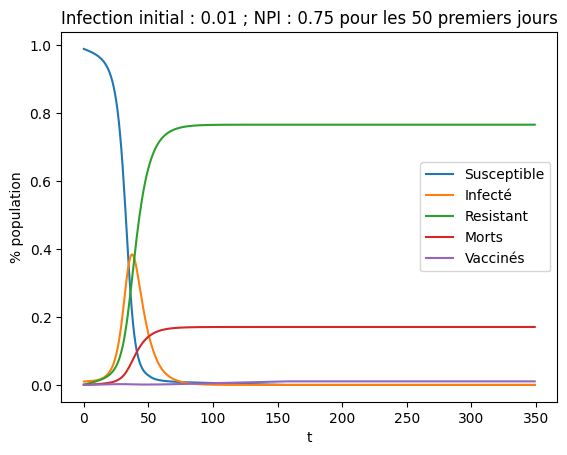

Nombre de morts : 0.1706%


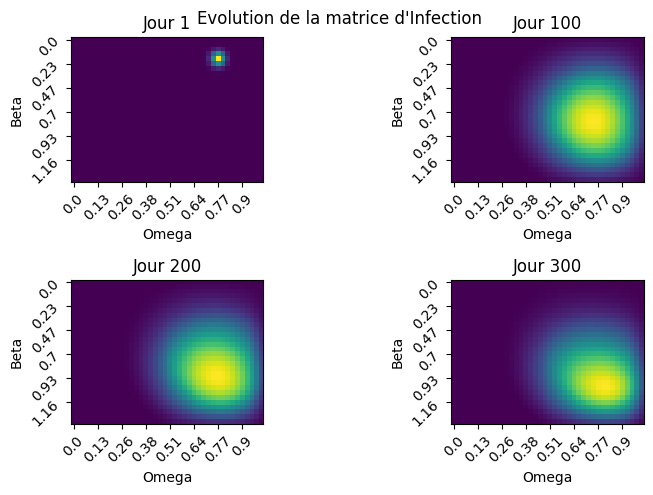

In [250]:
n = np.ones(T) * 0.0001 # Taux de vaccination
eta = np.concatenate(([0.75 for _ in range(50)], [1 for _ in range(T-50)])) # NPI
I0 = np.zeros((N, M)) # matrice des infections initiale
I0[i0, 30] = 10**-2
R0 = np.zeros((N, M)) # matrice des résistances initiale
R0[i0, j0] = 0.001
S0 = 1 - np.sum(I0) - np.sum(R0)
V0 = 0
D0 = 0

# Résultats et Affichage
S_l, I_l, R_l, V_l, D_l = simulation(S0, I0, R0, V0, D0, n, eta, 1, T)

Is_l = [np.sum(I_l[t]) for t in range(int(T/dt))]
Rs_l = [np.sum(R_l[t]) for t in range(int(T/dt))]

plot_simu(S_l, Is_l, Rs_l, D_l, V_l, 10**-2, "0.75 pour les 50 premiers jours")
print(f"Nombre de morts : {round(D_l[-1],4)}%")
plot_4_matrices(I_l)

#### Commentaire : 

Nous avons essayé un cas avec une absence totale de vaccin (ou presque) et un virus très contagieux. Les évènements se passent très rapidement malgré les restrictions imposés les 50 premiers jours. Le nombre de susceptible diminue drastiquement durant cette période avec l'augmentation des infections limités par la résistance développé par la population en parallèle et les décès. Les courbes se stabilisent emportant avec 17% de la population. Sur les matrices d'infections, on voit que les variantes sont déjà les plus extrêmes au jour 100 et une quasi-évolution nulle après. Remarque : les restrictions ont retardé ces évènements mais on garde à peu près les mêmes conséquences. Voir ci dessous.

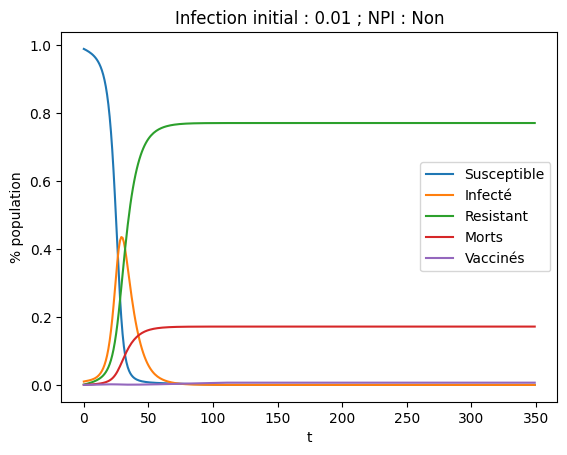

Nombre de morts : 0.1717%


In [251]:
n = np.ones(T) * 0.0001 # Taux de vaccination
eta = np.concatenate(([1 for _ in range(50)], [1 for _ in range(T-50)])) # NPI
I0 = np.zeros((N, M)) # matrice des infections initiale
I0[i0, 30] = 10**-2
R0 = np.zeros((N, M)) # matrice des résistances initiale
R0[i0, j0] = 0.001
S0 = 1 - np.sum(I0) - np.sum(R0)
V0 = 0
D0 = 0

# Résultats et Affichage
S_l, I_l, R_l, V_l, D_l = simulation(S0, I0, R0, V0, D0, n, eta, 1, T)

Is_l = [np.sum(I_l[t]) for t in range(int(T/dt))]
Rs_l = [np.sum(R_l[t]) for t in range(int(T/dt))]

plot_simu(S_l, Is_l, Rs_l, D_l, V_l, 10**-2, "Non")
print(f"Nombre de morts : {round(D_l[-1],4)}%")

## Contrôle optimal

Dans cette partie nous nous intéressons à l'application de méthodes appartenant au champ du contrôle optimal.

Nos paramètres de contrôle sont la politique de vaccination $n$ et la politique de restrictions $\eta$.

Nous prenons les hypothèses suivantes:

$$
\sup_{t \in [0,T]} n(t) \leq n_{\text{sup}}
$$

et 

$$
\inf_{t \in [0,T]} \eta(t) \geq \eta_{\text{INF}}
$$

La résolution du problème repose sur la résolution du système d'équations suivant:

$$
\frac{\partial p_{S}}{\partial t} (t) = -\eta(t)[p_{I}(t) \cdot \cdot ((\beta \otimes 1) \odot I(t))] + \eta(t)p_{S}(t)[((\beta \otimes 1) \cdot \cdot I(t))]
$$

$$
\frac{\partial p_{V}}{\partial t} (t) = -\eta(t)[p_{I}(t) \cdot \cdot ((\beta \otimes \omega) \odot I(t))] + \eta(t)p_{V}(t)[((\beta \otimes \omega) \cdot \cdot I(t))]
$$

$$
\frac{\partial p_{I}}{\partial t} (t) = \mu [p_{I}(t) - (1 \otimes 1)] + \gamma [pI(t) - p_{R}(t)] + \eta(t)[p_{S}(t)(\beta \otimes 1) - p_{I}(t) \odot (\beta \otimes 1)]S(t) + \eta(t)[p_{V}(t)(\beta \otimes \omega) - p_{I}(t) \odot (\beta \otimes \omega)]V(t) - P_{(3,4,1,2)} (P_I \otimes \Psi'(P..I - I)) + P_I \otimes \Psi'(P..I - I) - \eta(t)[pI(t) \otimes (\xi R(t))] + \eta(t)[\xi R(t) \otimes P(t)]
$$

$$
\frac{\partial p_{R}}{\partial t} (t) = -\eta(t)I(t) \odot (\xi_{(3,4,1,2)} p_{I} ) + \eta(t)I(t) \odot (\xi PR(t))
$$

$$
p(T) = 0
$$

where $p(t) = (p_{S}(t),p_{I}(t),p_{R}(t), p_{V}(t))$ is an adjoint-state



### Méthode 1

#### Fonction additionnelles

In [252]:
# fonctions additionnelles
def dpsi(x):
    if abs(x) < h:
        return 0
    elif abs(x) > 2 * h:
        return 1
    elif x <= 2 * h  and x >= h:
        return -9 * (x**2)/(h**2) + 28 * x / h - 19
    elif x <= -h and x >= -2 * h:
        return -9 * (x**2)/(h**2) - 28 * x / h - 19 

def Dpsi(X):
    return np.array([dpsi(e) for e in X.reshape(X.size)]).reshape(X.shape)

def make_P():
    return np.array([[[[1/(2*np.pi*sigma**2)*np.exp(-((i-k)**2+(j-l)**2)/(2*sigma**2)) for l in range(M)] for k in range(N)] for j in range(M)] for i in range(N)])

def plot_n_eta(n,eta):
    fig, ax1 = plt.subplots()
    t_s = np.arange(len(n))/(len(n)/350)
    ax1.plot(t_s,n, 'b-', label='Courbe n')
    ax1.set_xlabel('t')
    ax1.set_ylabel('Pourcentage de vaccination', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(t_s,eta, 'r-', label='Courbe eta')
    ax2.set_ylabel('NPI', color='r')
    ax2.tick_params('y', colors='r')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()
P = make_P()

In [253]:
# dérivées additionnelles

def dpS(eta, pI, pS, I):
    return -eta * np.tensordot(pI,np.outer(Beta, np.ones(M)) * I, 2) \
        + eta * pS * np.tensordot(np.outer(Beta, np.ones(M)), I, 2)
    
def dpV(eta, pI, pV, I):
    return -eta * np.tensordot(pI,np.outer(Beta, Omega)* I, 2) \
        + eta * pV * np.tensordot(np.outer(Beta, Omega), I, 2)
        
def dpI(eta, pI, pS, pV, pR, I, R, S, V):
    return mu * (pI - np.outer(np.ones(N), np.ones(M))) \
        + gamma * (pI -pR) \
        + eta * (pS * np.outer(Beta, np.ones(M)) 
                + pI * np.outer(Beta, np.ones(M))) * S \
        + eta * (pV * np.outer(Beta, Omega) 
                - pI * np.outer(Beta, Omega)) * V \
        - np.tensordot(np.transpose(P, (2,3,0,1)), 
                       pI * Dpsi(gaussian_filter(I,sigma,mode='constant',cval=0) - I), 2) \
        + pI * Dpsi(gaussian_filter(I,sigma,mode='constant',cval=0) - I) \
        - eta * pI * np.tensordot(Xi, R, 2) \
        + eta * np.tensordot(np.transpose(Xi, (2,3,0,1)), R * pR, 2)

def dpR(eta, pI, pR, I):
    return -eta * np.tensordot(I * np.transpose(Xi,(2,3,0,1)), pI, 2)\
            +eta * np.tensordot(I, np.tensordot(Xi, pR, 2), 2)
            
def dHn(pV, pS):
    return pV - pS

def dHeta(pI, pS, pV, pR, I, R, S, V):
    return - pS * np.tensordot(np.outer(Beta, np.ones(M)), I, 2) * S \
        - pV * V * np.tensordot(np.outer(Beta, Omega), I, 2) \
        - np.tensordot(pR, np.tensordot(np.transpose(Xi, (2,3,0,1)), I, 2) * R, 2) \
        + np.tensordot(pI, np.outer(Beta, np.ones(M)) * I * S 
                       + np.outer(Beta, Omega) * I * V
                       + np.tensordot(Xi, R, 2) * I, 2)

In [264]:
def optimize_f(n, eta, eps, lambd, n_sup, eta_inf, it_max, dt, T, afficher = True):
    """Optimise les fonction n et eta

    Paramètres :
    - n (array) : Tableau de taille  représentant le taux de vaccination à chaque pas de temps.
    - eta (array) : Tableau de taille int(T/dt) représentant les interventions non pharmaceutiques (NPI) à chaque pas de temps.
    - eps (float) : Seuil de convergence pour l'algorithme d'optimisation.
    - lambd (float) : Facteur de pondération pour la mise à jour de n et eta.
    - n_sup (float) : Valeur maximale pour n.
    - eta_inf (float) : Valeur minimale pour eta.
    - it_max (int) : Nombre maximal d'itérations pour l'algorithme d'optimisation.
    - dt (float) : Taille du pas de temps.
    - T (float) : Durée totale.
    """
    n_steps = int(T/dt)
    converged = False
    it = 1
    start = time.time()
    while (not converged) and (it < it_max):
        # Calcul de S, I, R, V, D
        I = np.zeros((N, M))
        I[i0, j0] = 200 * 10**-5
        R = np.zeros((N, M))
        R[i0, j0] = 0.25
        S = 1 - np.sum(I) - np.sum(R)
        V = 0
        D = 0
        S_l, I_l, R_l, V_l, D_l = simulation(S, I, R, V, D, n, eta, dt, T)
        
        
        # Modification de n et eta
        pS = 0
        pI = np.zeros((N,M))
        pR = np.zeros((N,M))
        pV = 0
        Ln_l = np.zeros(n_steps)
        Le_l = np.zeros(n_steps)
        n_ = copy.deepcopy(n)
        eta_ = copy.deepcopy(eta)
        
        for t in reversed(range(0,n_steps)):
            # Calcul de Lambda_n et Lambda_eta
            S = S_l [t]
            V = V_l [t]
            I = I_l [t]
            R = R_l [t]
            
            Ln = dHn(pV, pS)
            Le = dHeta(pI, pS, pV, pR, I, R, S, V)

            Ln_l[t] = Ln
            Le_l[t] = Le
            
            # mise à jour de n et eta
            if  Ln < 0 :
                n[t] = (1 - lambd) * n[t] + lambd * n_sup
            else:
                n[t] = (1 - lambd) * n[t]

            if Le < 0:
                eta[t] = (1 - lambd) * eta[t] + lambd* eta_inf
            else:
                eta[t] = (1 - lambd) * eta[t] + lambd
        
            # Calcul des adjoints p_S, p_I, p_R, p_V, p_D
            pSp = dpS(eta[t], pI, pS, I)
            pIp = dpI(eta[t], pI, pS, pV, pR, I, R, S, V)
            pRp = dpR(eta[t], pI, pR, I)
            pVp = dpV(eta[t], pI, pV, I)
            # Newton
            pS = pS - dt * pSp
            pV = pV - dt * pVp
            pI = pI - dt * pIp
            pR = pR - dt * pRp
            
        # Convergence
        if np.linalg.norm(n-n_) < eps and np.linalg.norm(eta-eta_) < eps:
            converged = True
        
        if (it-1)%5 == 0:
            print("itération", it, "||n-n_|| = ", np.linalg.norm(n-n_), "||eta-eta_|| = ", np.linalg.norm(eta-eta_))
        
        if afficher : 
            if (it-1)%10 == 0:
                print(f"Courbes à l'itération {it}")
                Is_l = [np.sum(I_l[t]) for t in range(n_steps)]
                Rs_l = [np.sum(R_l[t]) for t in range(n_steps)]
                plot_simu(S_l, Is_l, Rs_l, D_l, V_l, 200 * 10**-5, "eta")
                plot_4_matrices(I_l)
                plot_n_eta(n,eta)
        if it == 1:
            tmps = time.time()-start
            print("Temps pour une itération : ", tmps)
        it += 1
    return n, eta, S_l, I_l, R_l, V_l, D_l

#### Optimisation de la vaccination dans le cas n°2

itération 1 ||n-n_|| =  0.027436472076416776 ||eta-eta_|| =  0.0
Courbes à l'itération 1


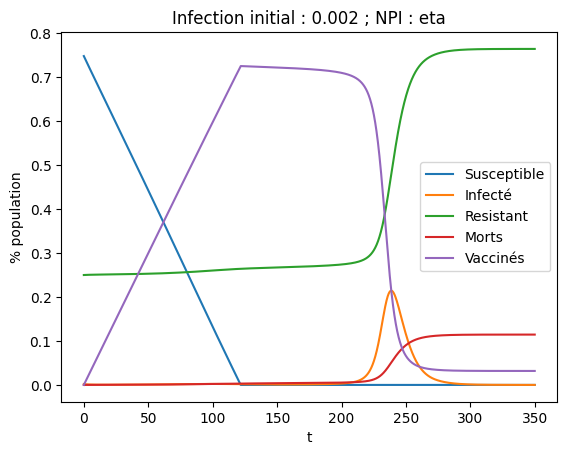

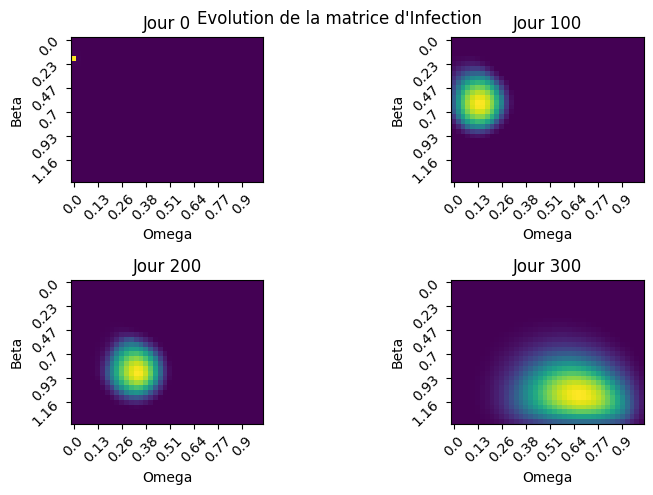

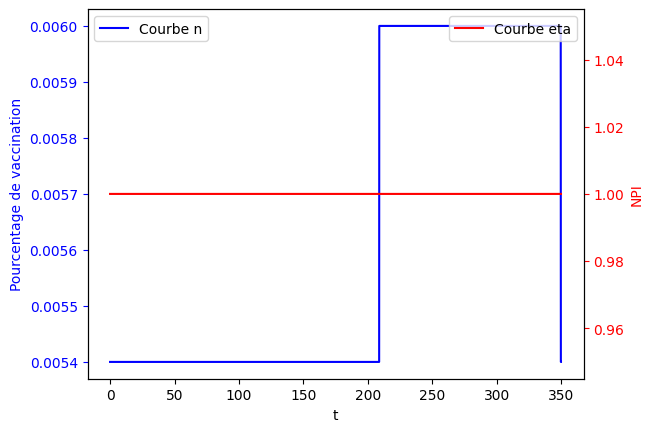

Temps pour une itération :  58.49815511703491
itération 6 ||n-n_|| =  0.010594385848736882 ||eta-eta_|| =  0.0
itération 11 ||n-n_|| =  0.006542722326192992 ||eta-eta_|| =  0.0
Courbes à l'itération 11


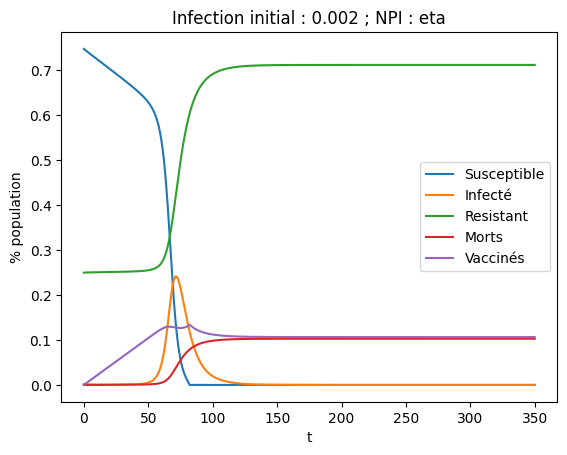

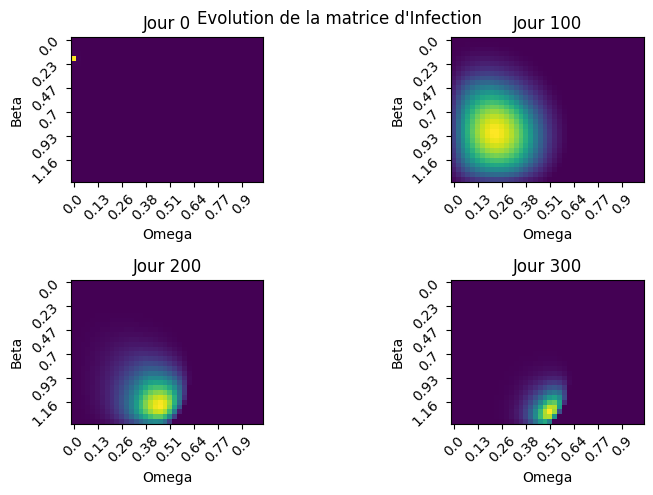

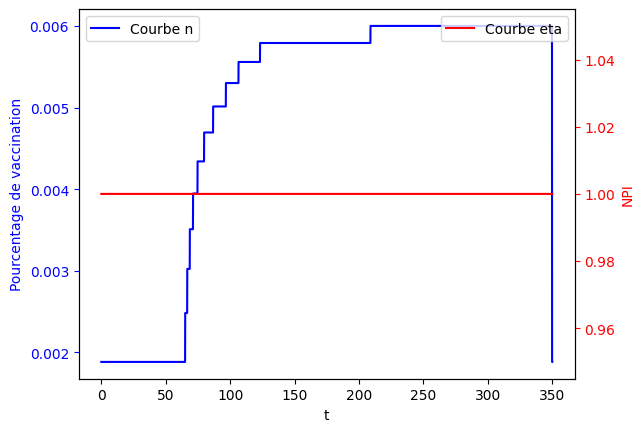

itération 16 ||n-n_|| =  0.00451028698909736 ||eta-eta_|| =  0.0
itération 21 ||n-n_|| =  0.00328799838070693 ||eta-eta_|| =  0.0
Courbes à l'itération 21


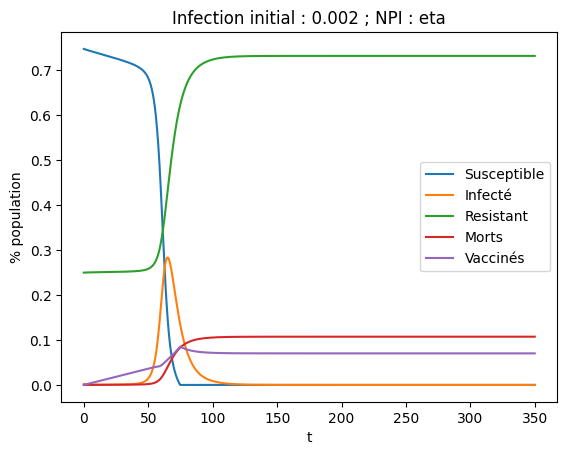

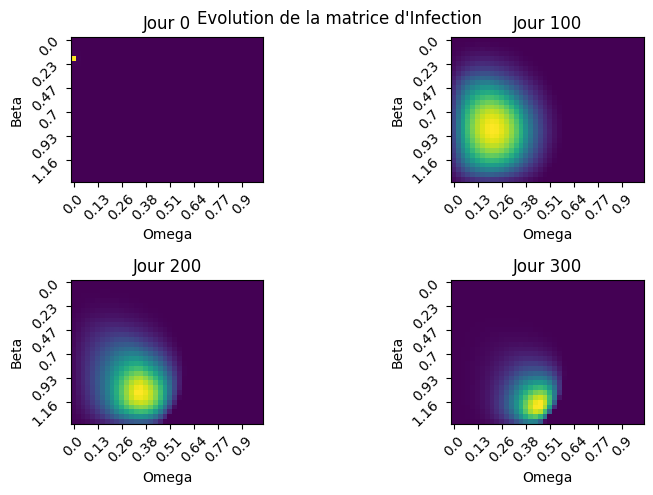

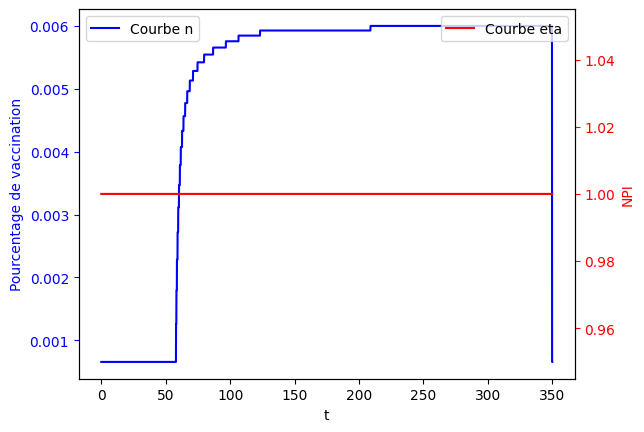

itération 26 ||n-n_|| =  0.0025001607133225113 ||eta-eta_|| =  0.0
itération 31 ||n-n_|| =  0.001906575644031947 ||eta-eta_|| =  0.0
Courbes à l'itération 31


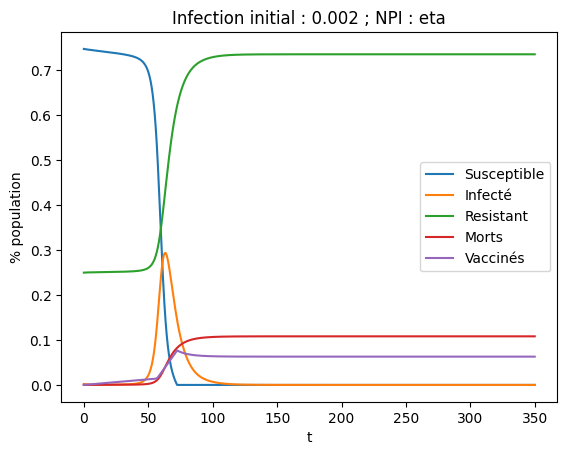

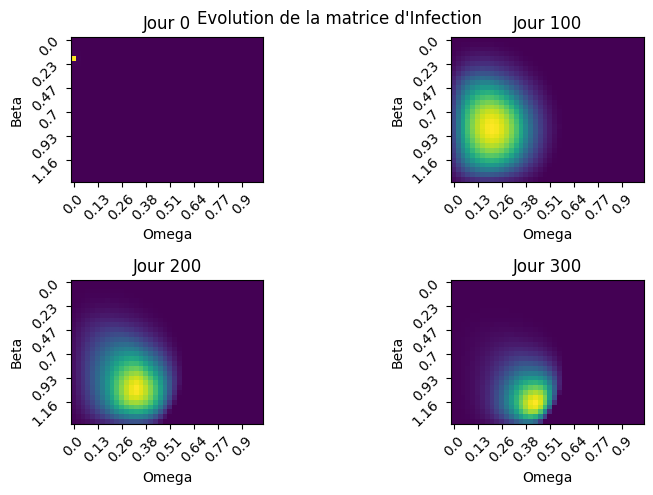

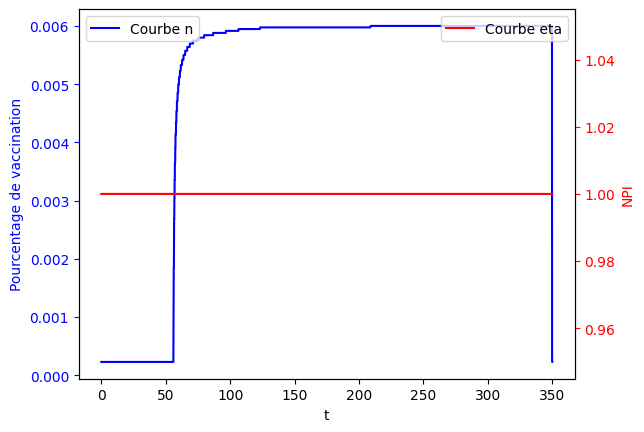

In [255]:
# initialisation

eta_inf = 1 # acceptabilité max des restriction (plus c'est grand, moins c'est acceptable)
n_sup = 0.006 # taux de vaccination max par jour
lambd = 0.1 # paramètre d'optiisation
dt = 0.1 # pas de temps
n_steps = int(T / dt)
eps = 2 * 10**-3 # seuil de convergence
it_max = 100 # nombre d'itérations maximum

eta = np.array([1 for _ in range(n_steps)])
n = np.array([n_sup for _ in range(n_steps)])
P = make_P()

# simulation
n, eta, S_l, I_l, R_l, V_l, D_l = optimize_f(n, eta, eps, lambd, n_sup, eta_inf, it_max, dt, T, afficher = True)

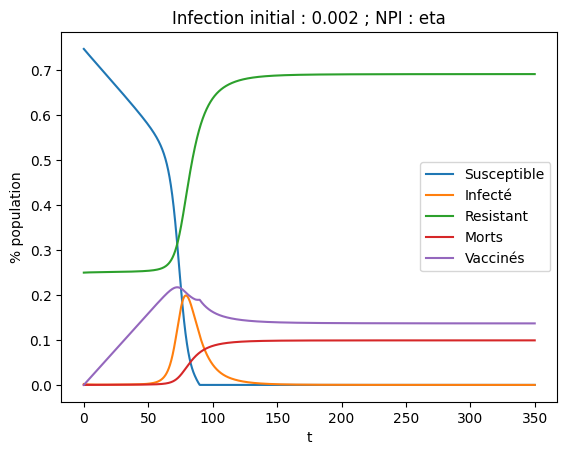

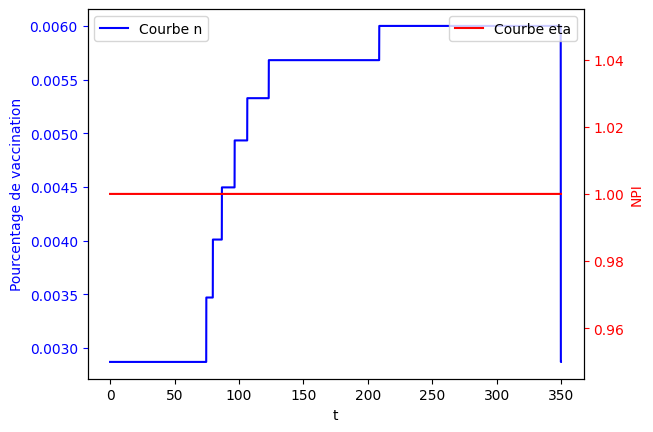

In [236]:
# Resultats et graphiques
Is_l = [np.sum(I_l[t]) for t in range(int(T/dt))]
Rs_l = [np.sum(R_l[t]) for t in range(int(T/dt))]

plot_simu(S_l, Is_l, Rs_l, D_l, V_l, 200 * 10**-5, "eta")
plot_n_eta(n,eta)

#### Commentaire : 

Ces courbes nous suggèrent de prime abord que la vaccination abrupte et instantanée n'est pas une stratégie optimale. En effet, comme nous l'avons vu dans le cas 2, une vaccination trop rapide peut mener à une résistance des variants au vaccin. Les courbes de vaccination que produisent cette simulation suggèrent une vaccination plus progressive.

Les courbes d'infection montrent une quantité d'infectés connaissant un pic et rebasculant vers zéro.
De même, la proportion de résistants augmente assez vite pour atteindre une proportion importante de la population de base.

En comparant le cas numéro 2 où la méthode était de vacciner tout le monde immédiatement, on remarque que relativement à la fenêtre totale de temps considéré, l'immunité survient plus tôt dans notre simulation fondée sur le contrôle optimal.

Cependant, le nombre de morts reste comparable dans les deux simulations (10% vs 11%).

### Si ça arrive par surprise, restrictions possible

itération 1 ||n-n_|| =  0.03260490760606455 ||eta-eta_|| =  0.1287439318958375
Courbes à l'itération 1


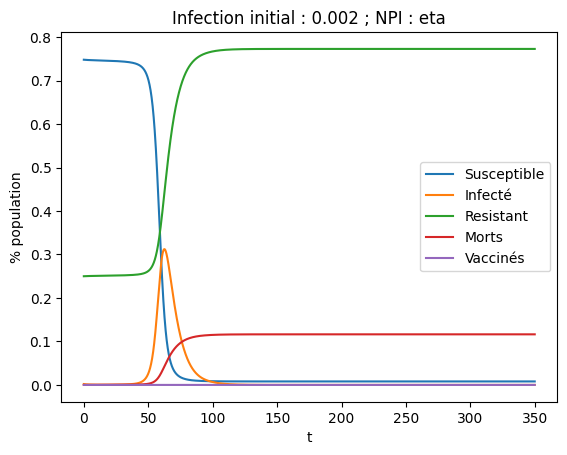

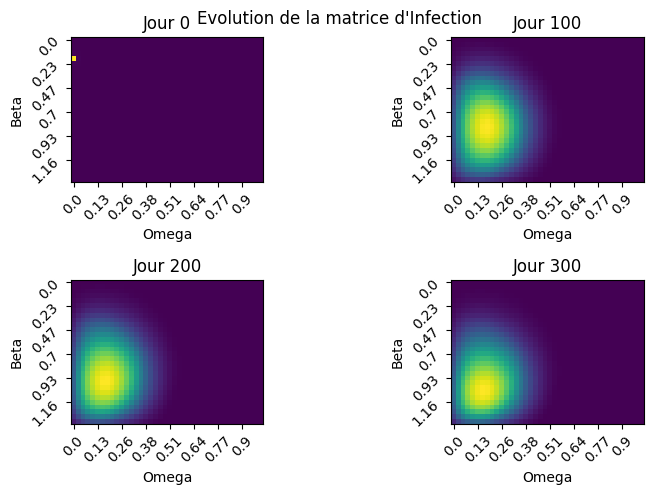

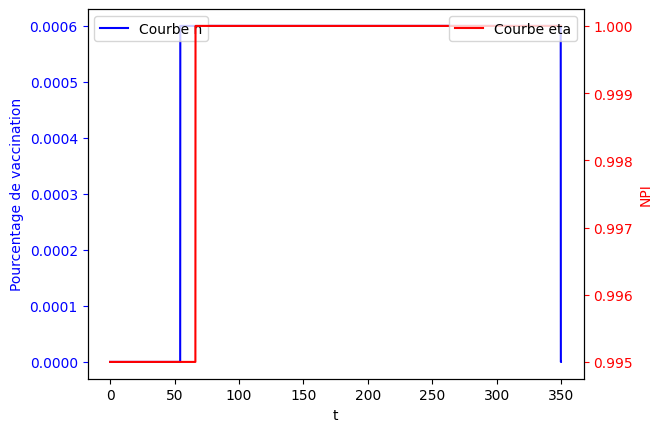

Temps pour une itération :  54.48030948638916
itération 6 ||n-n_|| =  0.019166280794100553 ||eta-eta_|| =  0.07829068275604377
itération 11 ||n-n_|| =  0.011339536517550132 ||eta-eta_|| =  0.04818596141527924
Courbes à l'itération 11


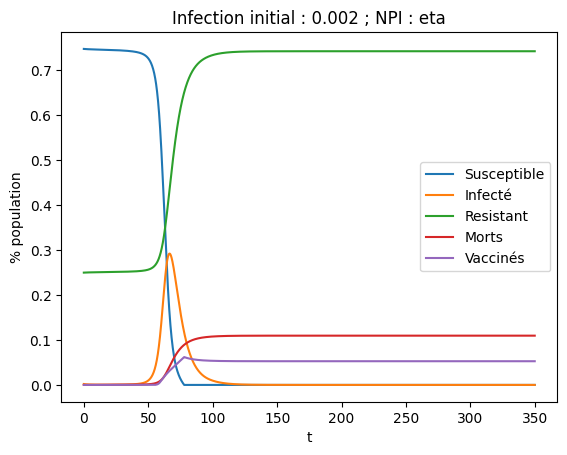

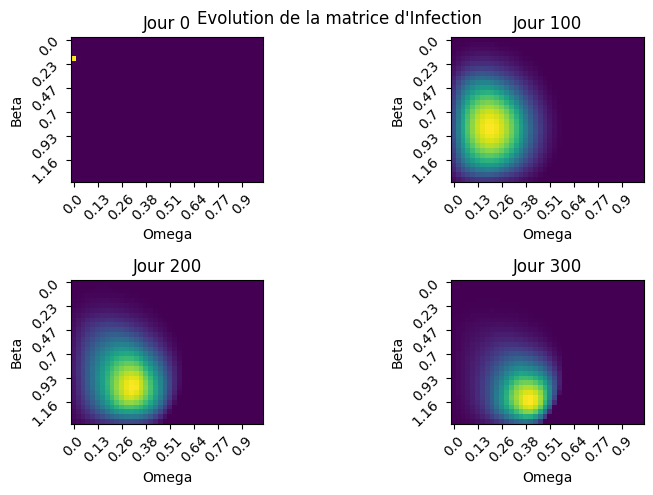

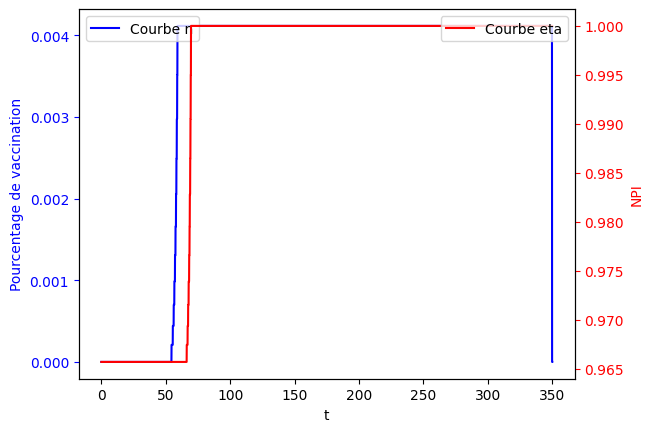

itération 16 ||n-n_|| =  0.006773265616018425 ||eta-eta_|| =  0.030652729161374428
itération 21 ||n-n_|| =  0.00408986839712705 ||eta-eta_|| =  0.02033014787957407
Courbes à l'itération 21


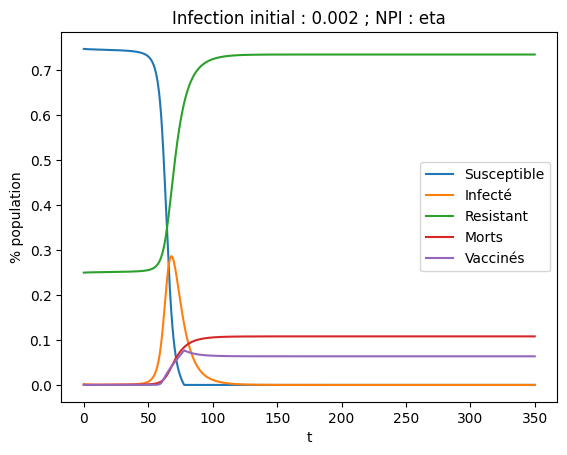

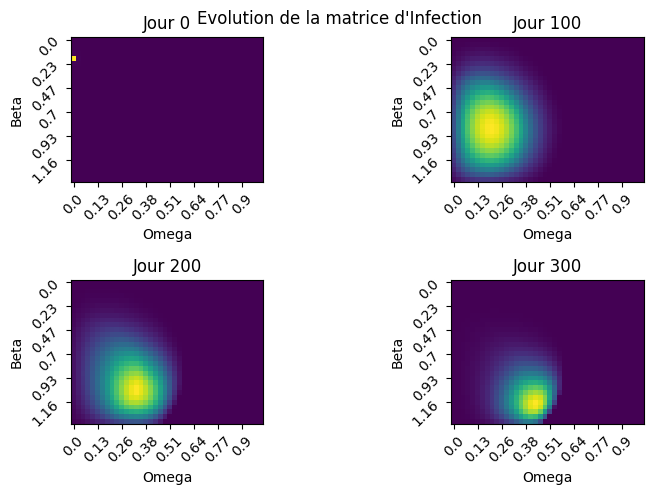

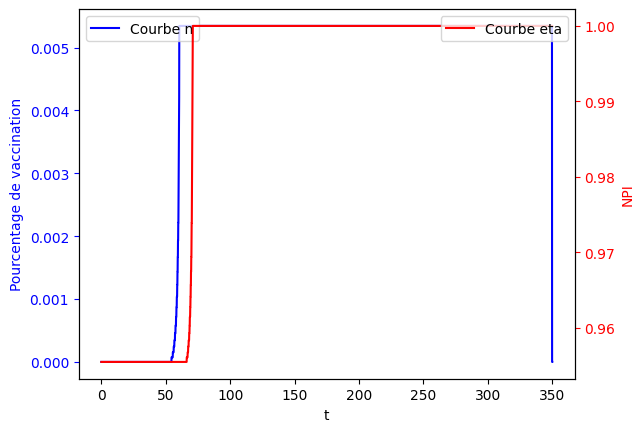

itération 26 ||n-n_|| =  0.002580782249282261 ||eta-eta_|| =  0.013328541708193227
itération 31 ||n-n_|| =  0.0015917990659589727 ||eta-eta_|| =  0.009439645836864661
Courbes à l'itération 31


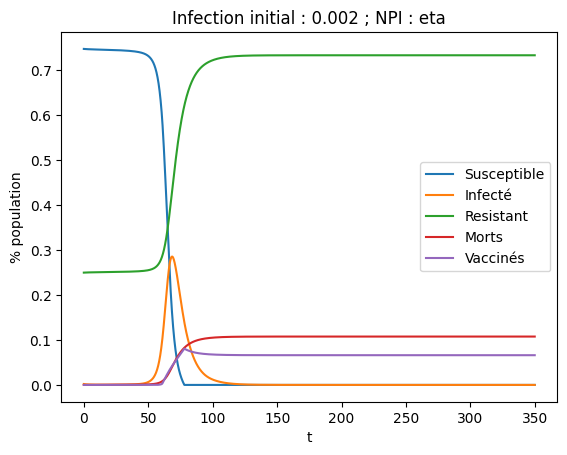

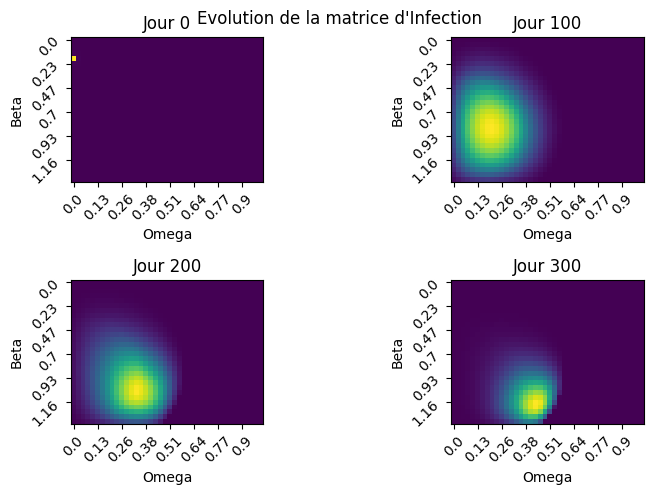

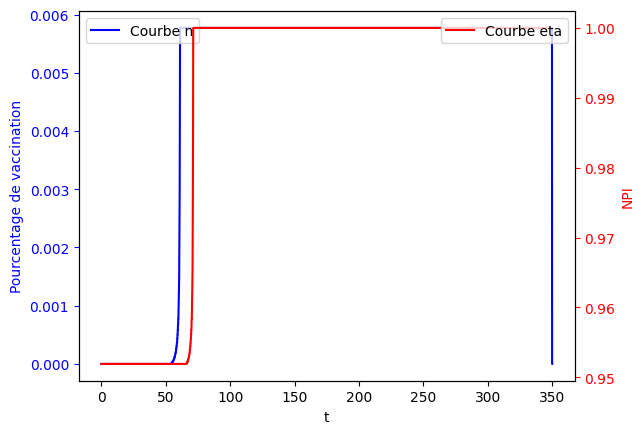

itération 36 ||n-n_|| =  0.0010132291852974105 ||eta-eta_|| =  0.006660006352112234
itération 41 ||n-n_|| =  0.0007113021516306768 ||eta-eta_|| =  0.005362079439866257
Courbes à l'itération 41


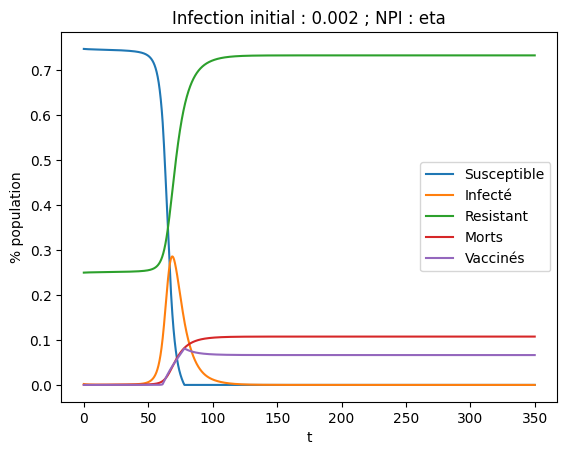

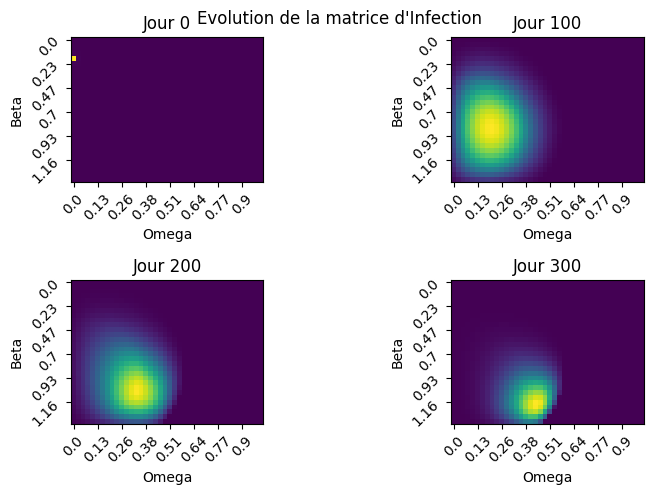

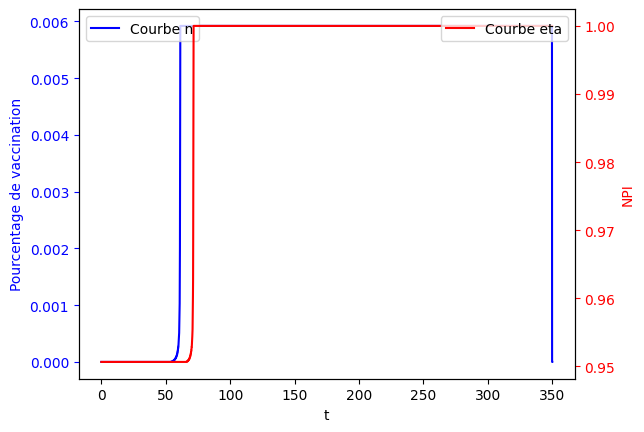

itération 46 ||n-n_|| =  0.00042001680751639484 ||eta-eta_|| =  0.0031662542884464792
itération 51 ||n-n_|| =  0.0006463753410631397 ||eta-eta_|| =  0.001869641494784625
Courbes à l'itération 51


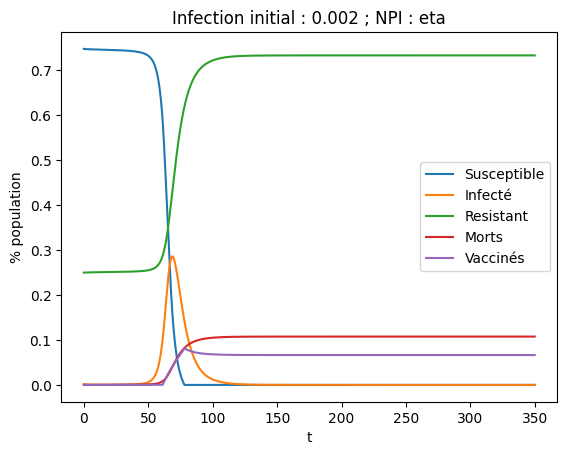

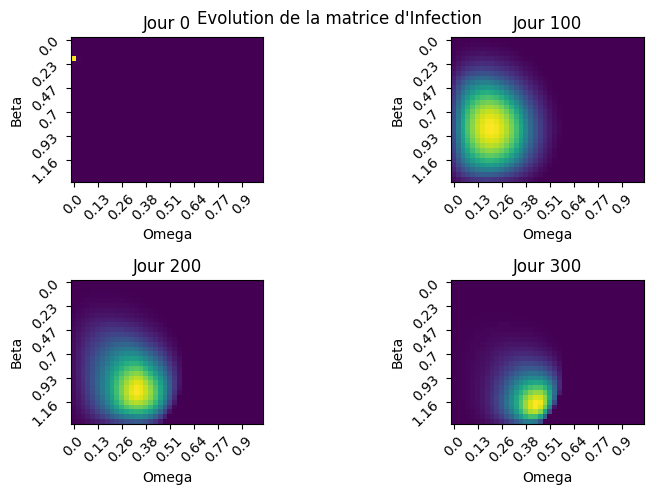

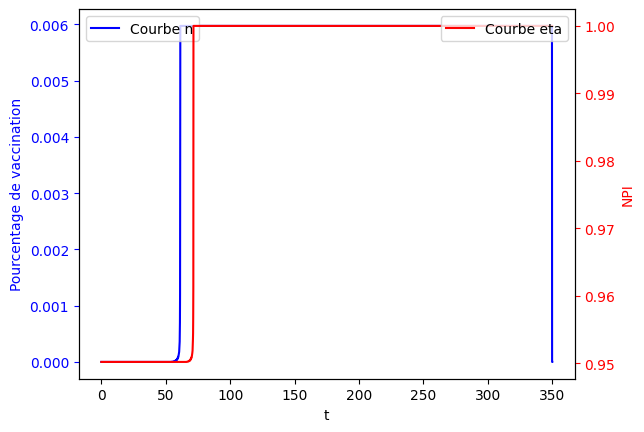

In [265]:
# initialisation

eta_inf = 0.95 # acceptabilité max des restriction (plus c'est grand, moins c'est acceptable)
n_sup = 0.006 # taux de vaccination max par jour
lambd = 0.1 # paramètre d'optiisation
dt = 0.1 # pas de temps
n_steps = int(T / dt)
eps = 2 * 10**-3 # seuil de convergence
it_max = 100 # nombre d'itérations maximum

eta = np.ones(n_steps)
n = np.zeros(n_steps)
P = np.fromfunction(lambda i,j,k,l : 1/(2*np.pi*sigma**2)*np.exp(-((i-k)**2+(j-l)**2)/(2*sigma**2)), (N,M,N,M))

# simulation
n, eta, S_l, I_l, R_l, V_l, D_l = optimize_f(n, eta, eps, lambd, n_sup, eta_inf, it_max, dt, T, afficher = True)

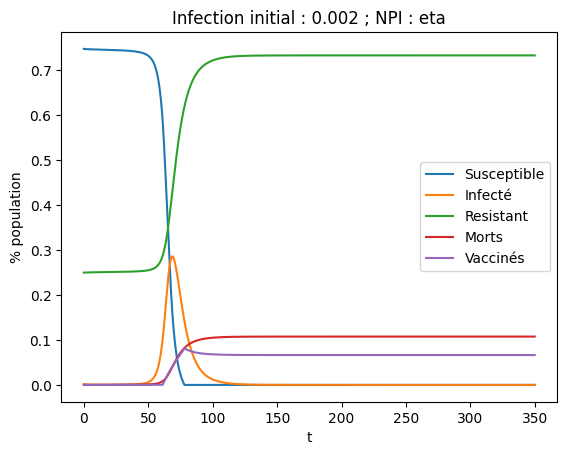

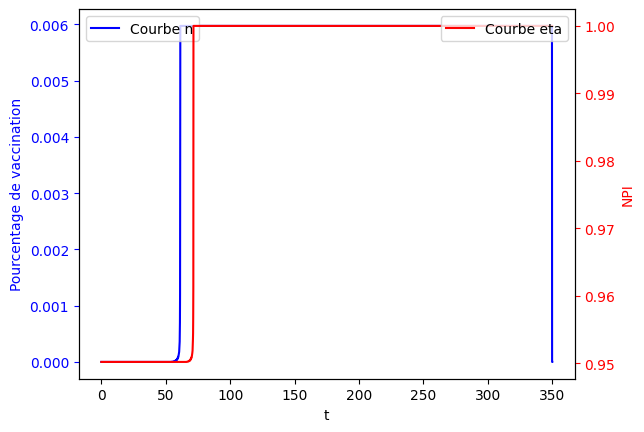

In [266]:
# Resultats et graphiques
Is_l = [np.sum(I_l[t]) for t in range(int(T/dt))]
Rs_l = [np.sum(R_l[t]) for t in range(int(T/dt))]

plot_simu(S_l, Is_l, Rs_l, D_l, V_l, 200 * 10**-5, "eta")
plot_n_eta(n,eta)